## Denoise Validation


In [174]:
import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor

import numpy as np
import anndata as ad

from scprint.tasks import Denoiser, withknn
from scdataloader.utils import downsample_profile
from scipy.stats import spearmanr
from anndata import AnnData
%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
# model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
# '../../data/main/gene_embeddings.parquet')
model = scPrint.load_from_checkpoint(
#    '../data/temp/o2uniqsx/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
    '../data/temp/1tghqqzx_dir/epoch=18-step=133000.ckpt', precpt_gene_emb=None)

# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
# ../../data/temp/za9mg1w3/epoch=7-step=40000.ckpt
# post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

RuntimeError caught: scPrint is not attached to a `Trainer`.



In [ ]:
#'/pasteur/appa/scratch/jkalfon/scprint/.lamindb/R4ZHoQegxXdSFNFY5LGe.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/SHV11AEetZOms4Wh7Ehb.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/V6DPJx8rP3wWRQ43LMHb.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/Gz5G2ETTEuuRDgwm7brA.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/YyBdEsN89p2aF4xJY1CW.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/SO5yBTUDBgkAmz0QbG8K.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/r4iCehg3Tw5IbCLiCIbl.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/SqvXr3i3PGXM8toXzUf9.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/REIyQZE6OMZm1S3W2Dxi.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/rYZ7gs0E0cqPOLONC8ia.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/FcwMDDbAQPNYIjcYNxoc.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/fvU5BAMJrm7vrgDmZM0z.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad'

In [ ]:
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad')
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/R4ZHoQegxXdSFNFY5LGe.h5ad')
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/REIyQZE6OMZm1S3W2Dxi.h5ad')


adata.layers['true'] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 34132 × 70116
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered'

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


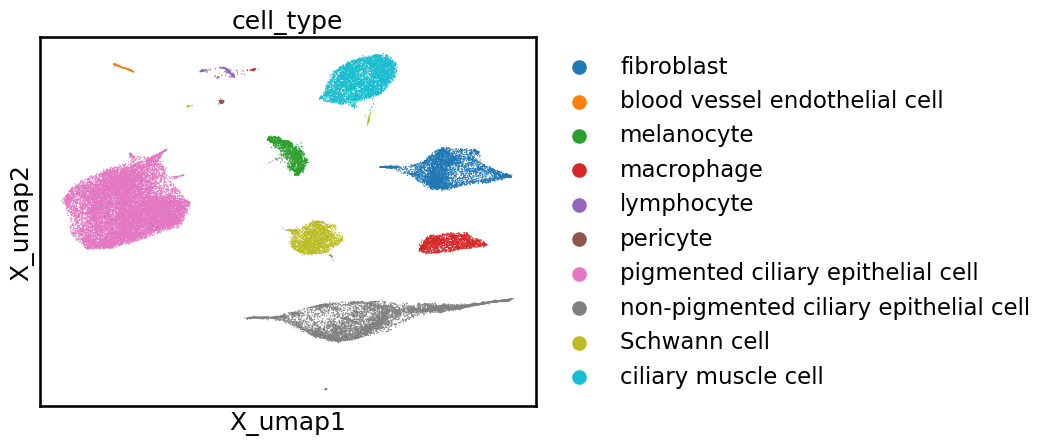

In [ ]:
sc.pl.embedding(adata, basis="X_umap", color='cell_type')

In [ ]:
adata.obs.cell_type.value_counts()

cell_type
endothelial cell                                             8719
kidney proximal convoluted tubule epithelial cell            2036
kidney distal convoluted tubule epithelial cell              1066
leukocyte                                                     996
podocyte                                                      518
kidney interstitial fibroblast                                468
blood vessel smooth muscle cell                               462
kidney collecting duct principal cell                         455
kidney loop of Henle thick ascending limb epithelial cell     388
kidney collecting duct intercalated cell                      367
macrophage                                                     88
macula densa epithelial cell                                   81
kidney granular cell                                           74
mesangial cell                                                 10
Name: count, dtype: int64

## regular denoise

In [178]:
model.normalization = "log"

In [181]:
denoise = Denoiser(
    model,
    batch_size=30,
    max_len=5000,
    plot_corr_size=10_000,
    doplot=False,
    num_workers=8,
    predict_depth_mult=10,
    downsample = 0.7,
    how="most var"
)
metrics, idx, genes, expr = denoise(adata)
metrics

5000


100%|██████████| 334/334 [02:38<00:00,  2.11it/s]


{'reco2noisy': 0.0587230587909589,
 'reco2full': 0.5115710051038211,
 'noisy2full': 0.3458865169667319}

# aggregate with KNN

In [182]:
subadata = AnnData(X=expr.cpu().numpy(), obs=adata.obs.iloc[idx], var=adata.var.loc[genes])

In [185]:
nadata = withknn(subadata, seed=42, k=10)

Performing kNN-smoothing v2.1 with k=10, d=10, and dither=0.030...
Step 1/4: Smooth using k=2
Step 1/4: Smooth using k=2
	PCA took 0.6 s.
	The fraction of variance explained by the top 10 PCs is 57.9 %.
	Calculating pair-wise distance matrix took 0.9 s.
	Calculating the smoothed expression matrix took 6.4 s.
Step 2/4: Smooth using k=4
	PCA took 0.6 s.
	The fraction of variance explained by the top 10 PCs is 72.2 %.
	Calculating pair-wise distance matrix took 0.8 s.
	Calculating the smoothed expression matrix took 6.4 s.
Step 3/4: Smooth using k=8
	PCA took 0.5 s.
	The fraction of variance explained by the top 10 PCs is 81.9 %.
	Calculating pair-wise distance matrix took 0.9 s.
	Calculating the smoothed expression matrix took 6.7 s.
Step 4/4: Smooth using k=10
	PCA took 0.7 s.
	The fraction of variance explained by the top 10 PCs is 88.0 %.
	Calculating pair-wise distance matrix took 0.8 s.
	Calculating the smoothed expression matrix took 6.5 s.
kNN-smoothing finished in 32.7 s.


In [186]:
reco = nadata.layers['denoised']
true = adata.X[idx][:, adata.var.index.isin(genes)].toarray()
noisy = np.loadtxt("collator_output.txt")
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.137829846030993,
 'reco2full': 0.3709222773794356,
 'noisy2full': 0.3458865169667319}

# on random expr

In [ ]:
denoise = Denoiser(
    model,
    batch_size=40,
    max_len=2200,
    plot_corr_size=5_000,
    doplot=False,
    predict_depth_mult=10,
    downsample = 0.7,
    how="random expr"
)
metrics, idx, genes, expr = denoise(adata)
metrics

100%|██████████| 125/125 [00:45<00:00,  2.72it/s]


{'reco2noisy': 0.7151437850641974,
 'reco2full': 0.3239858026438798,
 'noisy2full': 0.1896732525309344}

## with MAGIC

In [162]:
genes = torch.load('../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=5000, span=0.99)

In [163]:
random_indices = np.random.choice(
    adata.shape[0], size=10_000, replace=False
)
subadata = adata[random_indices, adata.var.index.isin(genes) & adata.var.highly_variable].copy()
subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)


In [164]:
denoised_adata = sc.external.pp.magic(subadata.copy(), copy=True, n_jobs=10, solver='approximate', verbose=True)

/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):


Calculating MAGIC...


/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(


  Running MAGIC on 10000 cells and 3215 genes.


/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):


  Calculating graph and diffusion operator...


    Calculating PCA...
    Calculated PCA in 3.88 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.74 seconds.
    Calculating affinities...
    Calculated affinities in 4.80 seconds.
  Calculated graph and diffusion operator in 13.47 seconds.


/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:748: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("imputation"):


  Calculating imputation...
  Calculated imputation in 0.11 seconds.
  Calculated imputation in 0.11 seconds.
Calculated MAGIC in 14.12 seconds.


In [165]:
reco = denoised_adata.X
true = subadata.layers['true'].toarray()
noisy = subadata.X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.2332537420283647,
 'reco2full': 0.5902201434290297,
 'noisy2full': 0.36316565975829096}

## same, with KNN

In [166]:
nadata = withknn(subadata, seed=42, k=10)

Performing kNN-smoothing v2.1 with k=10, d=10, and dither=0.030...
Step 1/4: Smooth using k=2
Step 1/4: Smooth using k=2
	PCA took 0.5 s.
	The fraction of variance explained by the top 10 PCs is 20.1 %.
	Calculating pair-wise distance matrix took 1.2 s.
	Calculating the smoothed expression matrix took 6.5 s.
Step 2/4: Smooth using k=4
	PCA took 0.5 s.
	The fraction of variance explained by the top 10 PCs is 31.1 %.
	Calculating pair-wise distance matrix took 1.4 s.
	Calculating the smoothed expression matrix took 6.5 s.
Step 3/4: Smooth using k=8
	PCA took 0.4 s.
	The fraction of variance explained by the top 10 PCs is 44.8 %.
	Calculating pair-wise distance matrix took 1.3 s.
	Calculating the smoothed expression matrix took 6.7 s.
Step 4/4: Smooth using k=10
	PCA took 0.4 s.
	The fraction of variance explained by the top 10 PCs is 58.9 %.
	Calculating pair-wise distance matrix took 1.3 s.
	Calculating the smoothed expression matrix took 6.5 s.
kNN-smoothing finished in 33.9 s.


In [167]:
reco = nadata.layers['denoised']#.toarray()
true = subadata.layers['true'].toarray()
noisy = subadata.X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.3864444078166065,
 'reco2full': 0.5799849865166642,
 'noisy2full': 0.36316565975829096}

## with MAGIC rare cells

In [168]:
ct = "pericyte"
subadata
#microglial cell, microfold cell of epithelium of small intestine, mesangial cell, pericyte

AnnData object with n_obs × n_vars = 10000 × 3215
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered',

In [169]:
reco = denoised_adata[subadata.obs.cell_type==ct].X
true = subadata[subadata.obs.cell_type==ct].layers['true'].toarray()
noisy = subadata[subadata.obs.cell_type==ct].X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.16739547347403197,
 'reco2full': 0.40762284286749056,
 'noisy2full': 0.3610326755364074}

## MAGIC Rare cell without support

In [170]:
subadata = adata[adata.obs.cell_type==ct, adata.var.index.isin(genes)]
sc.pp.highly_variable_genes(
    subadata, flavor="seurat_v3", n_top_genes=5000, span=0.99)

In [171]:
subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)

In [172]:
denoised_adata = sc.external.pp.magic(subadata[:,subadata.var.highly_variable][:30], knn=5, n_jobs=20, solver='approximate', copy=True)

/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):
/home/ml4ig1/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 100 dimensions on data with min(n_samples, n_features) = 30
  warnings.warn(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:748: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_ta

In [173]:
reco = denoised_adata.X
true = subadata[subadata.obs.cell_type==ct, subadata.var.highly_variable].layers['true'][:30].toarray()
noisy = subadata[subadata.obs.cell_type==ct, subadata.var.highly_variable][:30].X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.3116307487080801,
 'reco2full': 0.4477594810317442,
 'noisy2full': 0.3117786337560895}

## scPRINT rare cells

In [ ]:
denoise = Denoiser(
    model,
    batch_size=40,
    max_len=5000,
    plot_corr_size=30,
    doplot=False,
    predict_depth_mult=10,
    downsample = 0.7,
    how="most var"
)
metrics, idx, genes, expr = denoise(adata[adata.obs.cell_type==ct])
metrics

5000


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


{'reco2noisy': 0.7122362370625847,
 'reco2full': 0.3170816393649402,
 'noisy2full': 0.20527492811994658}